## Policy Gradients
The objective of a Reinforcement Learning agent is to maximize the “expected” reward when following a policy π. Like any Machine Learning setup, we define a set of parameters θ (e.g. the coefficients of a complex polynomial or the weights and biases of units in a neural network) to parametrize this policy — π_θ​ (also written a π for brevity). If we represent the total reward for a given trajectory τ as r(τ), we arrive at the following definition.


Reinforcement Learning Objective: Maximize the “expected” reward following a parametrized policy

All finite MDPs have at least one optimal policy (which can give the maximum reward) and among all the optimal policies at least one is stationary and deterministic.
Like any other Machine Learning problem, if we can find the parameters θ⋆ which maximize J, we will have solved the task. A standard approach to solving this maximization problem in Machine Learning Literature is to use Gradient Ascent (or Descent). In gradient ascent, we keep stepping through the parameters using the following update rule

Here comes the challenge, how do we find the gradient of the objective above which contains the expectation. Integrals are always bad in a computational setting. We need to find a way around them. First step is to reformulate the gradient starting with the expansion of expectation (with a slight abuse of notation).

The Policy Gradient Theorem: The derivative of the expected reward is the expectation of the product of the reward and gradient of the log of the policy π_θ​.

Now, let us expand the definition of π_θ​(τ).

To understand this computation, let us break it down — P represents the ergodic distribution of starting in some state s_0​. From then onwards, we apply the product rule of probability because each new action probability is independent of the previous one (remember Markov?). At each step, we take some action using the policy π_θ​ and the environment dynamics p decide which new state to transition into. Those are multiplied over T time steps representing the length of the trajectory. Equivalently, taking the log, we have

This result is beautiful in its own right because this tells us, that we don’t really need to know about the ergodic distribution of states P nor the environment dynamics p. This is crucial because for most practical purposes, it hard to model both these variables. Getting rid of them, is certainly good progress. As a result, all algorithms that use this result are known as “Model-Free Algorithms” because we don’t “model” the environment.
The “expectation” (or equivalently an integral term) still lingers around. A simple but effective approach is to sample a large number of trajectories (I really mean LARGE!) and average them out. This is an approximation but an unbiased one, similar to approximating an integral over continuous space with a discrete set of points in the domain. This technique is formally known as Markov Chain Monte-Carlo (MCMC), widely used in Probabilistic Graphical Models and Bayesian Networks to approximate parametric probability distributions.
One term that remains untouched in our treatment above is the reward of the trajectory r(τ). Even though the gradient of the parametrized policy does not depend on the reward, this term adds a lot of variance in the MCMC sampling. Effectively, there are T sources of variance with each R_t​ contributing. However, we can instead make use of the returns G_t​ because from the standpoint of optimizing the RL objective, rewards of the past don’t contribute anything. Hence, if we replace r(τ) by the discounted return G_t​, we arrive at the classic algorithm Policy Gradient algorithm called REINFORCE. This doesn’t totally alleviate the problem as we discuss further.


https://towardsdatascience.com/policy-gradients-in-a-nutshell-8b72f9743c5d

Loop:
    Collect trajectories (transitions - (state, action, reward, next state, terminated flag))
    (Optionally) store trajectories in a replay buffer for sampling
    Loop:
        Sample a mini batch of transitions
        Compute Policy Gradient
        (Optionally) Compute Critic Gradient
        Update parameters
        



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
sns.set()
tf.compat.v1.disable_eager_execution()
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
print(tf.__version__)

2.0.0


In [3]:
df = pd.read_csv('/Users/gkumargaur/workspace/python/gitprojects/Stock-Prediction-Models/dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2020-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2020-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2020-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2020-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [4]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.compat.v1.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.compat.v1.placeholder(tf.float32, (None))
        self.ACTIONS = tf.compat.v1.placeholder(tf.int32, (None))
        feed_forward = tf.compat.v1.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.compat.v1.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.math.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(input_tensor=loglike * (rewards + 1))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r

    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [5]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/Users/gkumargaur/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


epoch: 10, total rewards: 91.259949.3, cost: -11985.993164, total money: 10091.259949
epoch: 20, total rewards: 22.950011.3, cost: -13533.096680, total money: 10022.950011
epoch: 30, total rewards: 99.070068.3, cost: -14936.446289, total money: 10099.070068
epoch: 40, total rewards: 117.765010.3, cost: -16244.135742, total money: 10117.765010
epoch: 50, total rewards: 140.934935.3, cost: -17042.113281, total money: 10140.934935
epoch: 60, total rewards: -49.729919.3, cost: -18125.164062, total money: 9950.270081
epoch: 70, total rewards: 53.530033.3, cost: -18553.566406, total money: 10053.530033
epoch: 80, total rewards: 124.020205.3, cost: -19472.611328, total money: 10124.020205
epoch: 90, total rewards: 81.950074.3, cost: -20201.484375, total money: 10081.950074
epoch: 100, total rewards: 214.829957.3, cost: -19956.599609, total money: 10214.829957
epoch: 110, total rewards: 30.209970.3, cost: -20652.427734, total money: 10030.209970
epoch: 120, total rewards: 685.640017.3, cost: -

In [6]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1: buy 1 unit at price 762.130005, total balance 8469.169983
day 4, sell 1 unit at price 790.510010, investment 2.837257 %, total balance 9259.679993,
day 6: buy 1 unit at price 762.559998, total balance 8497.119995
day 7, sell 1 unit at price 754.020020, investment -1.064121 %, total balance 9251.140015,
day 8, sell 1 unit at price 736.080017, investment -3.472511 %, total balance 9987.220032,
day 13: buy 1 unit at price 769.200012, total balance 9218.020020
day 14, sell 1 unit at price 768.270020, investment -0.120904 %, total balance 9986.290040,
day 16: buy 1 unit at price 761.679993, total balance 9224.610047
day 17, sell 1 unit at price 768.239990, investment 0.861254 %, total balance 9992.850037,
day 18: buy 1 unit at price 770.840027, total balance 9222.010010
day 19: buy 1 unit at price 758.039978, total balance 8463.970032
day 21, sell 1 unit at price 750.500000, investment -2.638683 %, total balance 9214.47

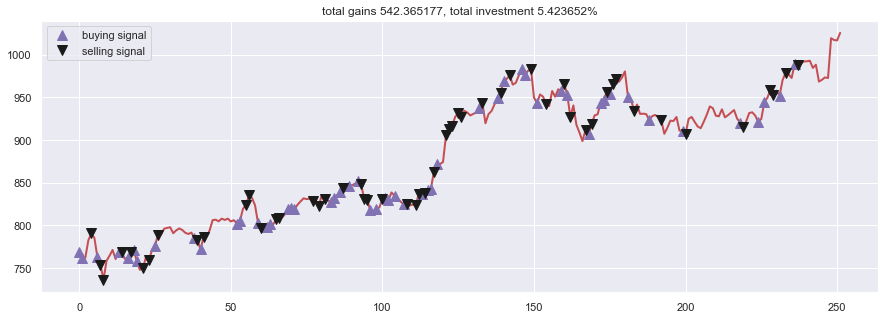

In [7]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()